## Librerias

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

## Importamos la base de datos ya limpia

In [11]:
filepath = 'C:/Users/Ramiro/Desktop/Digital House/Desafios/HLTB Scrapper/DB Input Modelo.csv'
df = pd.read_csv('C:/Users/Ramiro/Desktop/Digital House/Desafios/HLTB Scrapper/DB Input Modelo.csv', sep ='|')
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df.head()

,Id,Titulo,Main Story,Main + Extras,Completionist,All Styles,Rating,console_IOS,console_GAME BOY,console_ONLIVE,...,pub_MUMBOJUMBO,pub_VIVA MEDIA,pub_GT INTERACTIVE,pub_KEMCO,pub_DAGESTAN TECHNOLOGY,pub_BLACK SHELL MEDIA,pub_SLITHERINE,pub_SUNSOFT,pub_DEGICA,pub_EIDOS INTERACTIVE
0,1,688(I) Hunter/Killer,9.5,24.0,50.5,15.5,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Beyond Good & Evil 2,NaN,NaN,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,Ico and Shadow of the Colossus Collection,NaN,NaN,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16,Shadow of the Comet,NaN,NaN,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18,'Splosion Man,8.0,10.0,18.0,9.5,76.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#Seteamos el indice 
df = df.set_index(df['Id'])
df = df.drop(columns='Id')

# XGBoost

Empezamos probando como performa XGBoost con un dataset con valores nulos

In [32]:
#Elimino las observaciones que no tienen completa la variable objetivo
df_rating = df.dropna(subset = ['Rating'])

In [33]:
#Separo la matriz de features y la variable objetivo
X =  df_rating.drop(['Titulo','Rating'], axis = 1)
y = df_rating['Rating']

#Separo en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#Instancio el Clasificador de XGBoost
xg_reg = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear',\
                           booster='gbtree', n_jobs=-1)

In [34]:
%%time
#Fiteo el modelo
xg_reg.fit(X_train,y_train)

#Predicciones
preds = xg_reg.predict(X_test)

Wall time: 17.1 s


In [35]:
#Score
xg_reg.score(X_test, y_test)

0.2075300338990297

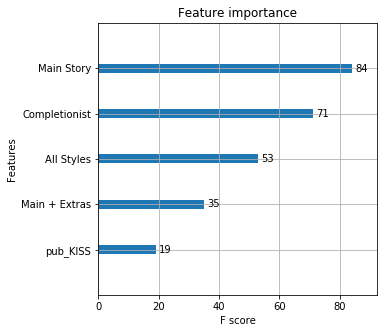

In [36]:
#Feature Importance
xgb.plot_importance(xg_reg, max_num_features=5)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

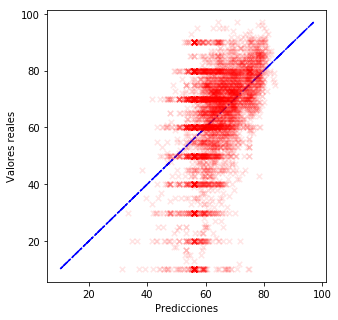

In [37]:
# Graficamos el modelo
plt.scatter(preds, y_test, alpha = 0.1,s=30, c='r', marker='x', zorder=10)
plt.plot(y,y, '-.',c='blue')
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

### Como podemos mejorar el score?

# XGBoost + GridSearch

In [ ]:
# Definimos una lista de hiperparametros a tunear
l2_reg_range = [3,5,7,10]
profundidad = [2,4,6,8,10]
learn_rate = [0.01,0.03,0.1]

In [ ]:
#Generamos la grilla para GridSearch
param_grid = dict(reg_lambda = l2_reg_range, max_depth=profundidad, learning_rate = learn_rate)
print(param_grid)

In [ ]:
%%time
# Instanciamos el modelo de XGBoost con los parametros de GridSearch y un cross validation de 5 folds
xgb_regressor = xgb.XGBRegressor(n_estimators=100, silent=True, objective='reg:linear',booster='gbtree')
xgb_gs = GridSearchCV(xgb_regressor, param_grid, cv = 5)
xgb_gs.fit(X_train, y_train)

In [ ]:
#Vemos los parametros del mejor modelo
xgb_gs.best_estimator_, xgb_gs.best_score_, xgb_gs.best_params_

## Utilizamos el mejor modelo para entrenar

In [12]:
xgb_best = xgb.XGBRegressor(n_estimators=100, silent=True, objective='reg:linear',booster='gbtree', n_jobs=-1, \
                           learning_rate = 0.1, max_depth=6,reg_lambda=10)
xgb_best.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [13]:
xgb_rating = xgb_best.score(X_test, y_test)
xgb_rating

0.22414392575899822

Con estos resultados, podriamos concluir que las variables explicativas no son suficientes o adecuadas para poder explicar el problema que queremos. Es decir, no pareciera que el Rating de un juego en particular dependiera de su genero, desarrollador, duracion, etc. <br>
Cabe preguntarse entonces, <b>es posible predecir la duracion de un juego en base al resto de las variables con las que contamos?

# Prediccion de duracion

In [25]:
#Elimino las observaciones que no tienen completa la variable objetivo
df_dur = df.dropna(subset = ['Main Story'])

In [45]:
#Separo la matriz de features y la variable objetivo. Dropeamos las otras columnas de duracion,
#ya que estan fuertemente correlacionados con la variable objetivo
X =  df_dur.drop(['Titulo','Main Story','Main + Extras','Completionist', 'All Styles'], axis = 1)
y = df_dur['Main Story']

#Separo en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#Instancio el Clasificador de XGBoost
xg_reg_dur = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear',\
                           booster='gbtree',reg_alpha = 0, reg_lambda = 10,  n_jobs=-1)

In [46]:
%%time
#Fiteo el modelo
xg_reg_dur.fit(X_train,y_train)

#Predicciones
preds = xg_reg_dur.predict(X_test)

Wall time: 19.5 s


In [47]:
#Score
xgb_dur = xg_reg_dur.score(X_test, y_test)
xgb_dur

0.3524315184141814

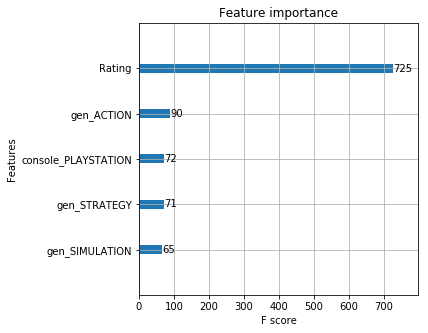

In [48]:
#Feature Importance
xgb.plot_importance(xg_reg_dur, max_num_features=5)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

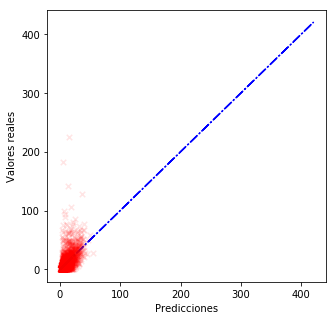

In [31]:
# Graficamos el modelo
plt.scatter(preds, y_test, alpha = 0.1,s=30, c='r', marker='x', zorder=10)
plt.plot(y,y, '-.',c='blue')
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

Si bien los resultados fueron un poco mejores que para predecir el Rating, no pareciera que las variables respondan al problema que queremos.<br>
Ahora, es esto un problema de las variables? O de la gran cantidad de nulos que presenta el dataset? <br>
Probemos entonces con un modelo de regresion lineal en un dataset completo

In [50]:
#Elimino todos los valores nulos
df_completo = df.dropna(how='any')

In [51]:
df_completo

,Titulo,Main Story,Main + Extras,Completionist,All Styles,Rating,console_IOS,console_GAME BOY,console_ONLIVE,console_ATARI 5200,...,pub_MUMBOJUMBO,pub_VIVA MEDIA,pub_GT INTERACTIVE,pub_KEMCO,pub_DAGESTAN TECHNOLOGY,pub_BLACK SHELL MEDIA,pub_SLITHERINE,pub_SUNSOFT,pub_DEGICA,pub_EIDOS INTERACTIVE
Id,,,,,,,,,,,,,,,,,,,,,
18,'Splosion Man,8.00,10.00,18.0,9.50,76.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,.hack//G.U. Vol. 1: Rebirth,20.50,26.50,38.0,24.50,80.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,.hack//G.U. Vol. 2: Reminisce,22.50,37.00,48.0,31.50,81.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,.hack//G.U. Vol. 3: Redemption,23.50,35.50,52.5,30.00,79.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,.hack//Infection,18.00,20.00,28.5,20.50,78.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,.hack//Mutation,16.50,21.00,32.0,21.00,78.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,.hack//Outbreak,19.50,20.00,20.5,20.00,75.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,.hack//Quarantine,17.50,20.50,24.5,20.00,75.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,007 Legends,6.50,8.50,9.5,7.00,49.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
from sklearn import linear_model
#Separamos en matriz de features y variable objetivo
X = df_completo.drop(['Titulo', 'Rating'], axis = 1)
y = df_completo['Rating']

In [131]:
#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=14)

#Instanciamos el modelo

lm = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal = lm.fit(X_train, y_train)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_rating = reg_lineal.score(X_test, y_test)

#Prediccion con el set de testeo

print('Score de Regresion Lineal:', reg_lineal.score(X_test, y_test))

Score de Regresion Lineal: 0.22032088295835617


## Como funciona la prediccion para la duracion?

In [132]:
#Separamos en matriz de features y variable objetivo
X = df_completo.drop(['Titulo', 'Main Story','Main + Extras', 'Completionist', 'All Styles'], axis = 1)
y = df_completo['Main Story']

In [184]:
#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

#Instanciamos el modelo

lm = linear_model.LinearRegression()

#Entrenamos el modelo
reg_lineal = lm.fit(X_train, y_train)

#Guardamos el score del modelo en una variable para poder comparar
R2_reg_lin_dur = reg_lineal.score(X_test, y_test)

#Prediccion con el set de testeo

print('Score de Regresion Lineal:', reg_lineal.score(X_test, y_test))

Score de Regresion Lineal: 0.42630134945041565


# Conclusion

Se puede observar que los resultados son ligeramente mejores con el dataset completo que con valores nulos en el mismo, sin embargo no llegan a ser lo suficientemente robustos como para poder asegurar que el modelo prediga correctamente.
Podemos conlcuir, entonces, que las variables elegidas no explican suficientemente el problema, por lo cual la regresion no arroja un valor lo suficientemente cercano al real como para confiar en el.

In [191]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['XGBoost', 'Regresion Lineal'],
    y=[xgb_rating,R2_reg_lin_rating],
    name='Prediccion Rating'
)
trace2 = go.Bar(
    x=['XGBoost', 'Regresion Lineal'],
    y=[xgb_dur,R2_reg_lin_dur],
    name='Prediccion Duracion'
)

data = [trace1, trace2]
layout = go.Layout(
    title = 'Comparacion de Modelos',
    yaxis=dict(
        range=[0, 1],
        tick0 = 0,
        dtick = 0.1        
    ),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')